# PROJET N°7 - Réalisez des indexations automatiques d’images

Deux approches sont présentées.

Une approche classique : il s’agit de pre-processer des images avec des techniques spécifiques (e.g. whitening, equalisation, filtre linéaire/laplacien/gaussien, éventuellement modifier la taille des images), puis d’extraire des features (e.g. texture, corners, edges et SIFT detector). 

Il faut ensuite réduire les dimensions, soit par des approches classiques (e.g. PCA, k-means) soit avec une approche par histogrammes et dictionary learning (bag-of-words appliqué aux images), puis appliquer des algorithmes de classification standards.

Lors de l’analyse exploratoire, vous regarderez si les features extraites et utilisées en classification sont prometteuses en utilisant des méthodes de réduction de dimension pour visualiser le dataset en 2D. Cela vous permettra d’affiner votre intuition sur les différents traitements possibles, sans que cela ne se substitue à des mesures de performances rigoureuses.

Une approche s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutionnels). Compte tenu de la taille et de la complexité du dataset, et de la puissance de calcul à votre disposition, il est très difficile d’obtenir de bonnes performances. 

Aussi, est-il recommandé d’utiliser le transfer learning, c’est-à-dire utiliser un réseau déjà entraîné, et le modifier pour répondre à votre problème. Une première chose obligatoire est de ré-entraîner les dernières couches pour prédire les classes qui vous intéressent seulement. 

Il est également possible d’adapter la structure (supprimer certaines couches par exemple) ou de ré-entraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.

In [26]:
# Libraries nécessaires au projet

import os
import random
import warnings
import numpy as np
import pandas as pd
import scipy.ndimage
from scipy.cluster.vq import whiten
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from tqdm import tqdm
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import RandomizedPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
import cv2

# Pour ne pas avoir les warnings lors de la compilation
warnings.filterwarnings("ignore")

# Variables globales

In [27]:
# Lieu où se trouvent des images
DOSSIER_SOURCE = '/home/toni/Bureau/p7/flow/'
IMG_DIR = '/home/toni/Bureau/p7/Images/'
SAVE_LIST = '/home/toni/Bureau/'

# Définitions des limites d'execution
NB_RACES = 5
NB_EXEMPLES = 200
NB_CLUSTER = int(NB_RACES * (NB_EXEMPLES/5))
AFFICHAGE_HISTOGRAMME = True
T_IMG = 224
BATCH_SIZE = 32
DATA_AUGMENTATION = False

RESULTATS = pd.DataFrame()

# Setup a standard image size
STANDARD_SIZE = (300, 167)

# Fonctions utiles

<p style='color:#5F04B4'><b>Gestion de l'erreur quand une catégorie de chien n'est pas prédite. On rajoute la colonne vide manuellement</b></p>

In [28]:
def gestion_erreur(res, test_y, labels, classifieur):

    # Si ce n'est pas un kmeans, le traitement est différent (noms ou numéros)
    if classifieur == 'kmeans':
        for i in range(0, NB_RACES):
            if i not in res.columns:
                res[i] = 0

        for i in np.unique(labels):
            if i not in res.index:
                res.loc[i] = 0

    elif classifieur == 'cnn':
        for i in res.index:
            if i not in res.columns:
                res[i] = 0
    else:
        for i in np.unique(test_y):
            if i not in res.columns:
                res[i] = 0

        for i in res.columns:
            if i not in res.index:
                res.loc[i] = 0

    res = res.sort_index(axis=0, ascending=True)
    res = res.sort_index(axis=1, ascending=True)

    return res

<p style='color:#5F04B4'><b>Les deux filtres qui sont testés</b></p>

In [29]:
def fonction_median(img, param1):
    """
    Fonction de filtre
    """

    # Application du filtre
    img_modified = scipy.ndimage.median_filter(img, size=param1)

    return img_modified

def fonction_gauss(img, param1):
    """
    Fonction de filtre
    """

    # Application du filtre
    img_modified = scipy.ndimage.filters.gaussian_filter(img, sigma=param1)

    return img_modified

<p style='color:#5F04B4'><b>Transformation d'une image dans un array Numpy</b></p>

In [30]:
def img_to_matrix(filename, verbose=False):

    img = Image.open(filename)

    if verbose:
        print("changing size from %s to %s" % (str(img.size), str(STANDARD_SIZE)))

    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = np.array(img)
    return img

<p style='color:#5F04B4'><b>Transformation d'un array Numpy en un array à 1 dimension</b></p>

In [31]:
def flatten_image(img):

    shape = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, shape)
    return img_wide[0]

<p style='color:#5F04B4'><b>Fonction qui récupére toute les images avec une sélection aléatoire. Rajout de filtres possibles</b></p>

In [32]:
def recup_images_filtres(liste_images, num_filtre):

    # Création des listes vides
    data = []

    for lien_image in liste_images:
        # Récupération de la matrice tranformée
        img = img_to_matrix(lien_image, False)

        if num_filtre == 1:
            # Filtre gaussien
            img = fonction_gauss(img, 5)
        elif num_filtre == 2:
            # Filtre médian
            img = fonction_median(img, 5)
        elif num_filtre == 3:
            img = whiten(img)

        # Mise à une dimension
        img = flatten_image(img)
        data.append(img)

        del img

    return data

<p style='color:#5F04B4'><b>Detection et extraction des features d'une image</b></p>

In [33]:
def features(img, extractor):

    img = cv2.imread(img)
    img = cv2.resize(img, STANDARD_SIZE)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, des = extractor.detectAndCompute(img, None)

    return keypoints, des

<p style='color:#5F04B4'><b>Fonction qui va calculer les pourcentages de bons pronostics.</b></p>


In [34]:
def calcul_resultats(res, test_y, classifieur, nom_filtre):

    global RESULTATS
        
    print("\nResultats pour", classifieur)

    # Transformation en tableau exploitable
    res1 = res.values

    data_resultats = pd.DataFrame(index=res.index, columns=['bons',
                                                            'prono',
                                                            'total',
                                                            'pc_prono',
                                                            'pc_total'])

    # Affichage des résultats
    print("Resultat :", round(100*res1.diagonal().sum()/len(test_y), 2), "%")
    print("No d'erreurs =", len(test_y) - res1.diagonal().sum(), "/", len(test_y))

    for i in range(0, len(res)):
        diagonale = res1.diagonal()[i]
        data_resultats.loc[res.index[i], 'bons'] = diagonale
        data_resultats.loc[res.index[i], 'prono'] = res.sum()[i]
        data_resultats.loc[res.index[i], 'total'] = res.sum('columns')[i]
        data_resultats.loc[res.index[i], 'pc_prono'] = round(100*diagonale/res.sum()[i], 2)
        data_resultats.loc[res.index[i], 'pc_total'] = round(100*diagonale/res.sum('columns')[i], 2)

    data_resultats = data_resultats.fillna(0)
    
    temp = []
    temp.append([classifieur,
                 nom_filtre,
                 data_resultats['pc_prono'].mean(),
                 data_resultats['pc_total'].mean()])

    RESULTATS = RESULTATS.append(temp)
    
    print(data_resultats)

<p style='color:#5F04B4'><b>Fonction qui extrait les features et permets de les clusterizer.</b></p>

In [35]:
def fonction_orb(liste_images):

    # Création des listes vides
    pool_descriptors = []

    #
    extractor = cv2.ORB_create()

    for lien_image in liste_images:
        # Récupération de la matrice tranformée
        keypoints, descriptors = features(lien_image, extractor)

        # Rajout à la liste
        pool_descriptors.append(descriptors)

    # Mise au bon format
    pool_descriptors = np.asarray(pool_descriptors)
    pool_descriptors = np.concatenate(pool_descriptors, axis=0)

    # Clusturisation des descriptors
    print("Training MiniBatchKMeans")
    kmeans = MiniBatchKMeans(n_clusters=NB_CLUSTER).fit(pool_descriptors)
    print("End training MiniBatchKMeans")

    return kmeans

<p style='color:#5F04B4'><b>Création de la liste aléatoire des chiens pour les races selectionnés.</b></p>

In [36]:
def etablir_liste_chiens():

    # Listes
    liste_dossier = []
    liste_images = []
    liste_images_cnn = []
    labels = []

    # Valeur initiale d'un compteur
    cpt_race = 0

    # Création de la liste aléatoire des races
    liste_chiens = os.listdir(IMG_DIR)
    for i in range(0, NB_RACES):
        nb_alea = random.randrange(0, len(liste_chiens))
        liste_dossier.append(liste_chiens[nb_alea])
        del liste_chiens[nb_alea]

    # Création de la liste aléatoire des chiens pour les races selectionnés
    for dirs in liste_dossier:
        # Valeur initiale d'un compteur
        cpt_exemple = 0
        if cpt_race < NB_RACES+1:
            cpt_race = cpt_race+1
            for filename in os.listdir(IMG_DIR + dirs):
                # On ne garde que NB_EXEMPLES exemplaires de chaque race
                if cpt_exemple < NB_EXEMPLES:
                    cpt_exemple = cpt_exemple+1

                    # Chemin complet de l'image
                    liste_images.append(IMG_DIR + dirs + '/' + filename)
                    liste_images_cnn.append(filename)

                    # Rajout du label
                    labels.append(dirs[dirs.find('-')+1:].lower())

    # Transformation de dataframe et exportation en csv
    liste_images_cnn = pd.DataFrame(liste_images_cnn, columns=['liste'])
    liste_images_cnn['labels'] = labels
    liste_images_cnn.to_csv(SAVE_LIST + 'liste.csv')
    
    return liste_images, labels

<p style='color:#5F04B4'><b>Création des centroids par la création des histogrammes des keypoints/features du kmeans.</b></p>

In [37]:
def calculate_centroids_histogram(liste_images, labels, model):

    # Création des listes vides
    feature_vectors = []
    class_vectors = []
    compteur = 0

    # Extracteur de features
    extractor = cv2.ORB_create() #cv2.xfeatures2d.SIFT_create()

    for lien_image in liste_images:
        # Récupération de la matrice tranformée
        keypoints, descriptors = features(lien_image, extractor)

        # classification of all descriptors in the model
        predict_kmeans = model.predict(descriptors)

        # calculates the histogram
        hist, bin_edges = np.histogram(predict_kmeans, bins=NB_CLUSTER)

        # Affichage des histogrammes
        if AFFICHAGE_HISTOGRAMME and compteur < 6:
            compteur = compteur + 1
            plt.hist(hist, bins=len(bin_edges), align='mid')
            plt.xlabel('bins')
            plt.ylabel('valeurs')
            plt.title('Histogramme')
            plt.show()

        # histogram is the feature vector
        feature_vectors.append(hist)

    # Mise sous la bonne forme
    feature_vectors = np.asarray(feature_vectors)
    class_vectors = np.asarray(labels)

    # return vectors and classes we want to classify
    return class_vectors, feature_vectors

<p style='color:#5F04B4'><b>Fonction avec utilise la technique bag of visual words.</b></p>

In [38]:
def fonction_bovw(liste_images, labels):

    print("\nFiltre ORB")

    # Séparation des datasets testing/training
    train_x, test_x, train_y, test_y = train_test_split(liste_images,
                                                        labels,
                                                        test_size=0.25)

    # Entrainement du modèle sur le dataset de training
    trained_model = fonction_orb(train_x)

    # Extraction des histogrammes
    [train_class, train_featvec] = calculate_centroids_histogram(train_x,
                                                                 train_y,
                                                                 trained_model)
    [test_class, test_featvec] = calculate_centroids_histogram(test_x,
                                                               test_y,
                                                               trained_model)

    # Utilisation des vecteurs de training pour entrainer le classifieur
    kmeans = KMeans(n_clusters=NB_RACES).fit(train_featvec, train_class)
    res = pd.crosstab(np.asarray(test_class),
                      kmeans.predict(test_featvec),
                      rownames=["Actual"],
                      colnames=["Predicted"])
        
    #clf = svm.SVC()
    #clf.fit(train_featvec, train_class)
    #predict = clf.predict(test_featvec)

    # Calcul des résultats
    #res = pd.crosstab(np.asarray(test_class),
    #                  predict,
    #                  rownames=["Actual"],
    #                  colnames=["Predicted"])

    # Gestion d'une erreur
    if len(res.columns) != NB_RACES:
        res = gestion_erreur(res, test_y, labels, 'kmeans')
    calcul_resultats(res, test_y, 'kmeans', 'orb')

    # Test avec KNN()
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(train_featvec, train_class)
    predict = knn.predict(test_featvec)

    # Calcul des résultats
    res = pd.crosstab(np.asarray(test_class),
                      predict,
                      rownames=["Actual"],
                      colnames=["Predicted"])

    # Gestion d'une erreur
    if len(res.columns) != NB_RACES:
        res = gestion_erreur(res, test_y, labels, 'knn')
    calcul_resultats(res, test_y, 'knn', 'orb')

<p style='color:#5F04B4'><b>Fonction avec filtres traditionnels.</b></p>

In [39]:
def fonction_filtres(liste_images, labels):

    for num_filtre in range(0, 4):
        if num_filtre == 0:
            nom_filtre = "Aucun"
        elif num_filtre == 1:
            nom_filtre = "Gaussien"
        elif num_filtre == 2:
            nom_filtre = "Median"
        elif num_filtre == 3:
            nom_filtre = "Whitening"

        print("\nFiltre", nom_filtre)
        data = recup_images_filtres(liste_images, num_filtre)

        ## Réduction de dimension
        # PCA
        pca = RandomizedPCA(n_components=2)
        data = pca.fit_transform(data)
        # Explication de la variance
        #print(pca.explained_variance_ratio_)

        # t-SNE
        #data = TSNE(n_components=2).fit_transform(data, labels)

        # Affichage en 2D après une décomposition
        affichage_decomposition(data, labels)

        # Séparation des datasets testing/training
        train_x, test_x, train_y, test_y = train_test_split(data,
                                                            labels,
                                                            test_size=0.25)

        # Transformation en array
        test_y = np.array(test_y)
        train_y = np.array(train_y)

        ## Création de la méthode de classification
        # Test avec KNN
        knn = KNeighborsClassifier(n_neighbors=10)
        knn.fit(train_x, train_y)
        res = pd.crosstab(test_y,
                          knn.predict(test_x),
                          rownames=["Actual"],
                          colnames=["Predicted"])

        # Gestion d'une erreur
        if len(res.columns) != NB_RACES:
            res = gestion_erreur(res, test_y, '0', 'knn')
        calcul_resultats(res, test_y, 'knn', nom_filtre)

        # Test avec Kmeans
        kmeans = KMeans(n_clusters=NB_RACES).fit(train_x, train_y)
        res = pd.crosstab(test_y,
                          kmeans.predict(test_x),
                          rownames=["Actual"],
                          colnames=["Predicted"])

        # Gestion d'une erreur
        if len(res.columns) != NB_RACES:
            res = gestion_erreur(res, test_y, labels, 'kmeans')
        calcul_resultats(res, test_y, 'kmeans', nom_filtre)

<p style='color:#5F04B4'><b>Affichage en 2D de la décomposition.</b></p>

In [40]:
def affichage_decomposition(data, labels):

    principaldf = pd.DataFrame(data=data,
                             columns=['principal component 1',
                                      'principal component 2'])

    finaldf = pd.concat([principaldf, pd.DataFrame(labels)], axis=1)

    data_labels = pd.DataFrame(labels)
    targets = []

    # Création de la liste des labels
    for i in data_labels[0].unique():
        targets.append(i)

    fig = plt.figure(figsize=(8, 8))
    axe = fig.add_subplot(1, 1, 1)
    axe.set_xlabel('Principal Component 1', fontsize=15)
    axe.set_ylabel('Principal Component 2', fontsize=15)
    axe.set_title('PCA components', fontsize=20)

    # Création de la liste des couleurs
    colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(targets)))

    # Affichage par catégorie
    for target, color in zip(targets, colors):
        indices_to_keep = finaldf[0] == target
        axe.scatter(finaldf.loc[indices_to_keep, 'principal component 1'],
                    finaldf.loc[indices_to_keep, 'principal component 2'],
                    c=color,
                    s=50)

    axe.legend(targets)
    axe.grid()
    plt.show()

# Fonctions utiles pour le cnn

<p style='color:#5F04B4'><b>Fonction pour la data augmentation.</b></p>

In [41]:
def cnn_data_augmentation(model, liste_train, liste_test):

    # DA pour le training
    train_datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                 width_shift_range=0.2,
                                                                 height_shift_range=0.2,
                                                                 shear_range=0.2,
                                                                 zoom_range=0.2,
                                                                 horizontal_flip=True)

    train_generator = train_datagen.flow_from_dataframe(dataframe=liste_train,
                                                        directory=DOSSIER_SOURCE,
                                                        x_col='liste',
                                                        y_col='labels',
                                                        has_ext=True,
                                                        target_size=(T_IMG, T_IMG),
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

    # DA pour la validation
    valid_datagen = keras.preprocessing.image.ImageDataGenerator()

    valid_generator = valid_datagen.flow_from_dataframe(dataframe=liste_test,
                                                        directory=DOSSIER_SOURCE,
                                                        x_col='liste',
                                                        y_col='labels',
                                                        has_ext=True,
                                                        target_size=(T_IMG, T_IMG),
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

    hist = model.fit_generator(train_generator,
                               steps_per_epoch=2000 // BATCH_SIZE,
                               epochs=25,
                               validation_data=valid_generator,
                               validation_steps=200 // BATCH_SIZE)

    return hist

<p style='color:#5F04B4'><b>Fonction de transfert learning.</b></p>

In [42]:
def cnn_appel_vgg(x_train, y_train, x_valid, y_valid,liste_train, liste_test):

    # On crée un modèle déjà pré entrainé
    base_model = VGG19(weights="imagenet", include_top=False, input_shape=(T_IMG, T_IMG, 3))

    # On rajoute les deux dernières couches qui nous intéressent
    x_model = base_model.output
    x_model = Flatten()(x_model)
    x_model = Dense(NB_RACES, activation='softmax')(x_model)

    # On crée notre modèle à partir de celui existant, et des deux couches en plus
    model = Model(inputs=base_model.input, outputs=x_model)

    # On choisi d'entrainer que nos couches rajoutées
    for layer in base_model.layers:
        layer.trainable = False

    # Compilatioon du modèle
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # On se donne des tours sans évolution pour stopper le fit
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc',
                                                    patience=5,
                                                    verbose=1)]

    # Visualisation de toutes les couches du modèle
    model.summary()

    if DATA_AUGMENTATION is True:
        res = cnn_data_augmentation(model, liste_train, liste_test)
    else:
        # Entrainement
        res = model.fit(x_train,
                        y_train,
                        epochs=10,
                        validation_data=(x_valid, y_valid),
                        verbose=1)

    # Tracé de courbes pour visualiser les résultats
    cnn_courbes(res)

    return model

<p style='color:#5F04B4'><b>Tracé des courbes d'accuracy et de log loss.</b></p>

In [43]:
def cnn_courbes(resultat):

    # Loss Curves
    plt.figure(figsize=[8, 6])
    plt.plot(resultat.history['loss'], 'r', linewidth=3.0)
    plt.plot(resultat.history['val_loss'], 'b', linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)

    # Accuracy Curves
    plt.figure(figsize=[8, 6])
    plt.plot(resultat.history['acc'], 'r', linewidth=3.0)
    plt.plot(resultat.history['val_acc'], 'b', linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)

<p style='color:#5F04B4'><b>Fonction de récupération des images.</b></p>

In [44]:
def cnn_recup_images():

    # Listes vides
    x_train = []
    y_train = []
    x_test = []

    # Récupération de la liste des images
    liste_images = pd.read_csv(SAVE_LIST + 'liste.csv')
    del liste_images['Unnamed: 0']
    
    # Séparation des datasets testing/training
    liste_train, liste_test = train_test_split(liste_images,
                                               test_size=0.2)

    liste_train = liste_train.reset_index(drop="True")
    liste_test = liste_test.reset_index(drop="True")

    # Préparation du one-hot encoding
    targets_series = pd.Series(liste_train['labels'])
    one_hot = pd.get_dummies(targets_series, sparse=True)
    one_hot_labels = np.asarray(one_hot)
    
    # Récupération des images et des labels de training
    i = 0
    for file, dump in tqdm(liste_train.values):
        # Lecture de l'image
        img = cv2.imread(DOSSIER_SOURCE + file)

        # Rajout des données dans la liste
        x_train.append(cv2.resize(img, (T_IMG, T_IMG)))

        # Race du chien
        y_train.append(one_hot_labels[i])
        i = i + 1

    # Récupération des images de testing
    for file in tqdm(liste_test['liste'].values):
        # Lecture de l'image
        img = cv2.imread(DOSSIER_SOURCE + file)

        # Rajout des données dans la liste
        x_test.append(cv2.resize(img, (T_IMG, T_IMG)))

    return liste_train, liste_test, x_train, y_train, x_test

# Fonction principale

In [45]:
# Etablir la liste des chiens
liste_images, labels = etablir_liste_chiens()


Filtre Aucun


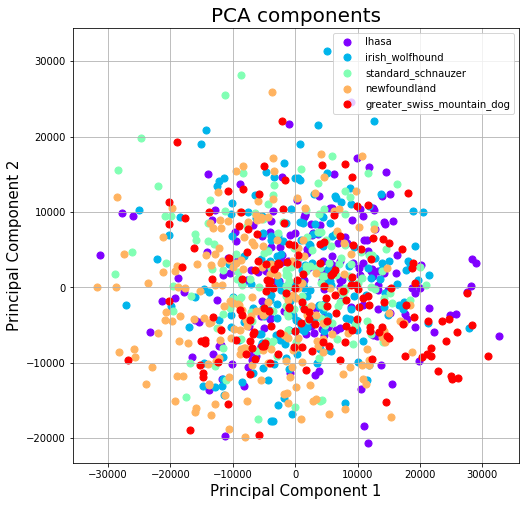


Resultats pour knn
Resultat : 28.76 %
No d'erreurs = 161 / 226
                            bons  prono  total  pc_prono  pc_total
Actual                                                            
greater_swiss_mountain_dog     9     45     42     20.00     21.43
irish_wolfhound               16     57     48     28.07     33.33
lhasa                         12     41     49     29.27     24.49
newfoundland                  23     65     46     35.38     50.00
standard_schnauzer             5     18     41     27.78     12.20

Resultats pour kmeans
Resultat : 29.2 %
No d'erreurs = 160 / 226
                            bons  prono  total  pc_prono  pc_total
Actual                                                            
greater_swiss_mountain_dog    16     59     42     27.12     38.10
irish_wolfhound               10     42     48     23.81     20.83
lhasa                         15     43     49     34.88     30.61
newfoundland                  15     39     46     38.46     32.61

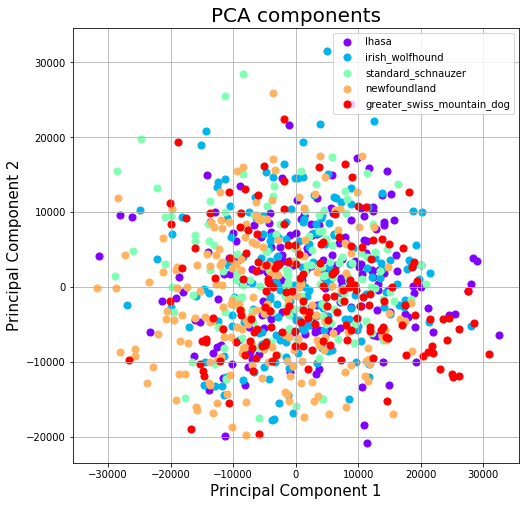


Resultats pour knn
Resultat : 26.11 %
No d'erreurs = 167 / 226
                            bons  prono  total  pc_prono  pc_total
Actual                                                            
greater_swiss_mountain_dog    10     38     49     26.32     20.41
irish_wolfhound               12     63     42     19.05     28.57
lhasa                         12     41     50     29.27     24.00
newfoundland                  21     64     47     32.81     44.68
standard_schnauzer             4     20     38     20.00     10.53

Resultats pour kmeans
Resultat : 15.49 %
No d'erreurs = 191 / 226
                            bons  prono  total  pc_prono  pc_total
Actual                                                            
greater_swiss_mountain_dog     3     37     49      8.11      6.12
irish_wolfhound               11     50     42     22.00     26.19
lhasa                          8     38     50     21.05     16.00
newfoundland                   4     41     47      9.76      8.5

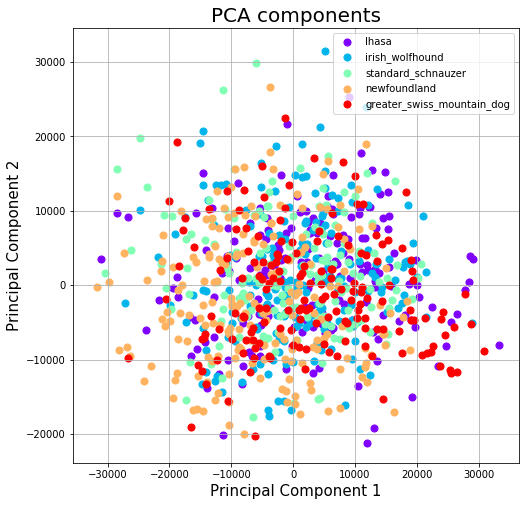


Resultats pour knn
Resultat : 25.66 %
No d'erreurs = 168 / 226
                            bons  prono  total  pc_prono  pc_total
Actual                                                            
greater_swiss_mountain_dog     9     36     55     25.00     16.36
irish_wolfhound               17     62     45     27.42     37.78
lhasa                         11     45     52     24.44     21.15
newfoundland                  18     61     42     29.51     42.86
standard_schnauzer             3     22     32     13.64      9.38

Resultats pour kmeans
Resultat : 18.58 %
No d'erreurs = 184 / 226
                            bons  prono  total  pc_prono  pc_total
Actual                                                            
greater_swiss_mountain_dog     4     34     55     11.76      7.27
irish_wolfhound               13     61     45     21.31     28.89
lhasa                         15     56     52     26.79     28.85
newfoundland                   5     40     42     12.50     11.9

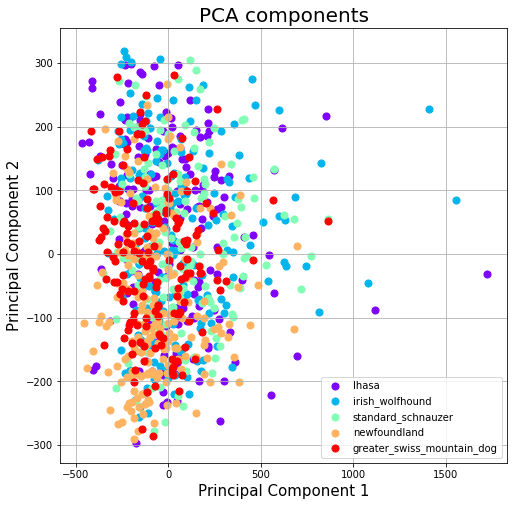


Resultats pour knn
Resultat : 28.76 %
No d'erreurs = 161 / 226
                            bons  prono  total  pc_prono  pc_total
Actual                                                            
greater_swiss_mountain_dog    16     66     40     24.24     40.00
irish_wolfhound               10     60     42     16.67     23.81
lhasa                         15     30     45     50.00     33.33
newfoundland                  19     49     53     38.78     35.85
standard_schnauzer             5     21     46     23.81     10.87

Resultats pour kmeans
Resultat : 19.91 %
No d'erreurs = 181 / 226
                            bons  prono  total  pc_prono  pc_total
Actual                                                            
greater_swiss_mountain_dog    13     68     40     19.12     32.50
irish_wolfhound               11     50     42     22.00     26.19
lhasa                         12     40     45     30.00     26.67
newfoundland                   0      8     53      0.00      0.0

In [46]:
fonction_filtres(liste_images, labels)


Filtre ORB
Training MiniBatchKMeans
End training MiniBatchKMeans


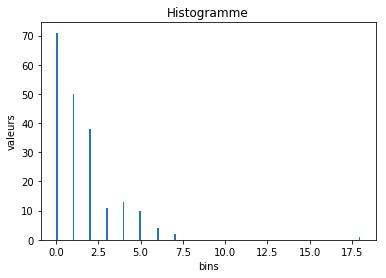

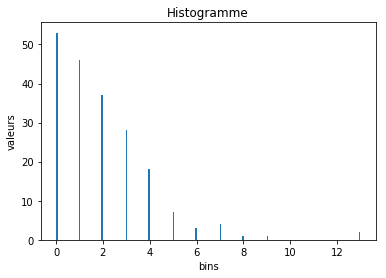

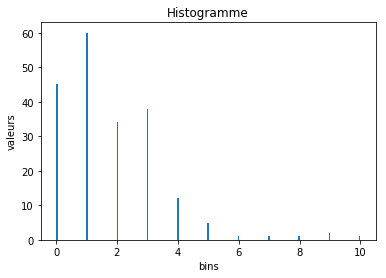

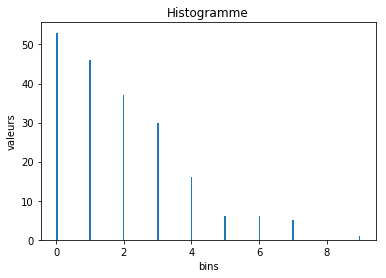

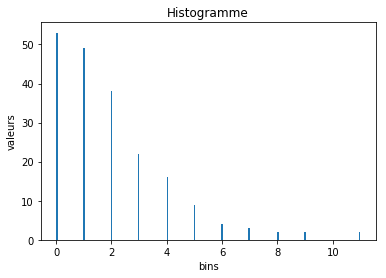

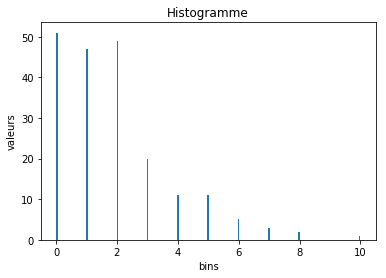

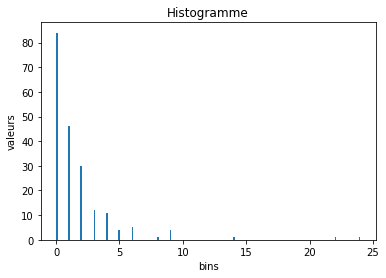

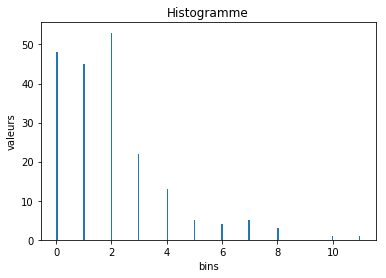

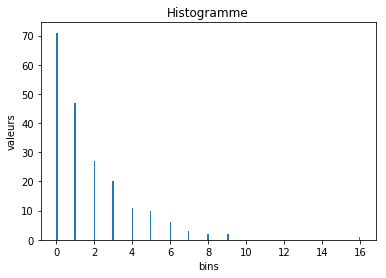

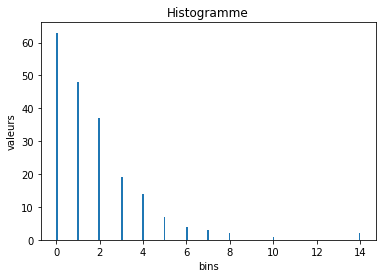

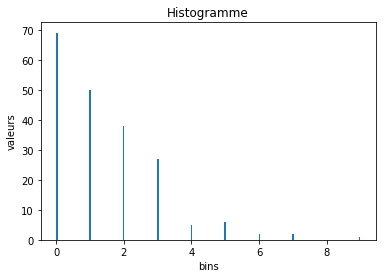

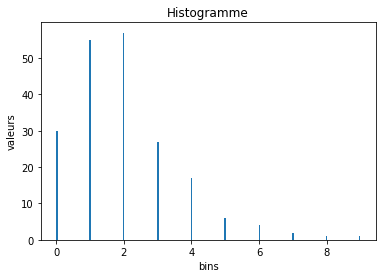


Resultats pour kmeans
Resultat : 20.8 %
No d'erreurs = 179 / 226
                            bons  prono  total  pc_prono  pc_total
Actual                                                            
greater_swiss_mountain_dog    10     47     36     21.28     27.78
irish_wolfhound                9     58     54     15.52     16.67
lhasa                          8     25     35     32.00     22.86
newfoundland                   4     27     60     14.81      6.67
standard_schnauzer            16     69     41     23.19     39.02

Resultats pour knn
Resultat : 34.51 %
No d'erreurs = 148 / 226
                            bons  prono  total  pc_prono  pc_total
Actual                                                            
greater_swiss_mountain_dog    11     48     36     22.92     30.56
irish_wolfhound               16     46     54     34.78     29.63
lhasa                         18     42     35     42.86     51.43
newfoundland                  30     82     60     36.59     50.00

In [47]:
fonction_bovw(liste_images, labels)

# Fonction principale pour le cnn

La liste des chiens a été récupérée un peu plus haut. Pour avoir des résultats comparables, on joue les tests sur le même dataset

In [48]:
# Récupération du même dataset
liste_train, liste_test, x_train, y_train, x_test = cnn_recup_images()
    
# Reformatage des listes pour le format de VGG19
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test = np.array(x_test, np.float32) / 255.

# Vérification des données
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test.shape)

# Séparation des datasets training/validation
x_train, x_valid, y_train, y_valid = train_test_split(x_train_raw,
                                                      y_train_raw,
                                                      test_size=0.3,
                                                      random_state=1)

100%|██████████| 181/181 [00:00<00:00, 312.16it/s]


(723, 224, 224, 3)
(723, 5)
(181, 224, 224, 3)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

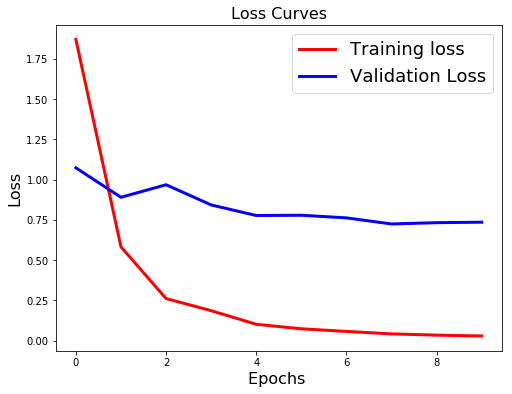

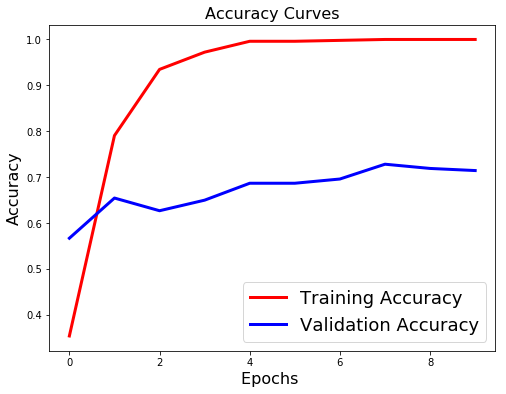

In [49]:
# Appel de la fonction de transfer learning
model = cnn_appel_vgg(x_train,
                      y_train,
                      x_valid,
                      y_valid,
                      liste_train,
                      liste_test)

In [50]:
# Calcul des résultats
predictions = model.predict(x_valid)
predictions = np.argmax(predictions, axis=1)
truth = np.argmax(y_valid, axis=1)

res = pd.crosstab(np.asarray(truth),
                  predictions,
                  rownames=["Actual"],
                  colnames=["Predicted"])

# Gestion d'une erreur
if len(res.columns) != NB_RACES:
    res = gestion_erreur(res, predictions, liste_train['labels'], 'cnn')
calcul_resultats(res, np.asarray(predictions), 'cnn', ' ')

errors = np.where(predictions != truth)[0]
print("No of errors =", len(errors), "/", len(predictions))


Resultats pour cnn
Resultat : 71.43 %
No d'erreurs = 62 / 217
        bons  prono  total  pc_prono  pc_total
Actual                                        
0         34     40     48     85.00     70.83
1         34     53     48     64.15     70.83
2         39     52     50     75.00     78.00
3         30     43     42     69.77     71.43
4         18     29     29     62.07     62.07
No of errors = 62 / 217


In [51]:
# Résultats globaux

RESULTATS.columns= ["nom", "nom2", "% prono", "% total"]
print(RESULTATS)

      nom       nom2  % prono  % total
0     knn      Aucun   28.100   28.290
0  kmeans      Aucun   29.506   29.308
0     knn   Gaussien   25.490   25.638
0  kmeans   Gaussien   15.184   16.100
0     knn     Median   24.002   25.506
0  kmeans     Median   17.330   18.506
0     knn  Whitening   30.700   28.772
0  kmeans  Whitening   17.224   20.986
0  kmeans        orb   21.360   22.600
0     knn        orb   34.930   33.788
0     cnn              71.198   70.632


# Configuration des CPU/GPU, ne pas lancer

In [52]:
#import keras
#import tensorflow as tf
#from tensorflow.python.client import device_lib
#from keras import backend as K

#config = tf.ConfigProto( device_count = {'CPU': 8} ) 
##config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
#sess = tf.Session(config=config) 
#keras.backend.set_session(sess)

#print(device_lib.list_local_devices())

#K.tensorflow_backend._get_available_gpus()

#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0, 1"